In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import quad
import cmath
from scipy.optimize import bisect, brentq
from scipy.stats import norm
from scipy.linalg import expm
from scipy.fft import fft, ifft, fftfreq


In [2]:
# We'll take t = T/2 everywhere, hence, there's no need to considère t for the rest

# CASE 1 : Shaun 2 (a, b, c, rho, V_0, T)
case_1  = 17.25*0.018,  -17.25, 2.95,-0.68,  0.006, 1.

#CASE 2 : Shaun 1
case_2 = 2.15*0.057,  -2.15, 0.86,-0.70, 0.023, 1.
    
#CASE 3 : ANDERSEN 1  (a, b, c, rho, V_0, T)
case_3 = 0.5*0.04,  -0.5, 1.,-0.9, 0.04, 10.

case = np.zeros([3, 6])
case[0,:], case[1,:], case[2,:] = case_1, case_2, case_3 

print(case)

[[ 3.1050e-01 -1.7250e+01  2.9500e+00 -6.8000e-01  6.0000e-03  1.0000e+00]
 [ 1.2255e-01 -2.1500e+00  8.6000e-01 -7.0000e-01  2.3000e-02  1.0000e+00]
 [ 2.0000e-02 -5.0000e-01  1.0000e+00 -9.0000e-01  4.0000e-02  1.0000e+01]]


In [3]:
# Algorithme de Micheal et al pour simuler une gaussienne inverse

def inverse_gaussian_sample_vectorized(mu, lambda_, x_n, x_u):
    """
    Vectorized version of the inverse Gaussian sampling function.
    """
    y = x_n ** 2  # std normal squared
    x = mu + (mu ** 2 * y) / (2 * lambda_) - (mu / (2 * lambda_)) * np.sqrt(4 * mu * lambda_ * y + mu ** 2 * y ** 2)
    condition = x_u <= mu / (mu + x)
    samples = np.where(condition, x, (mu ** 2) / x)
    return samples    

# Ivy Method

In [4]:
# Simulate n_paths sample paths of U, V, Z, logS with n time steps
def simulate_paths(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if (n_steps % 2)!=0:
        print("le nombre de pas doit être pair")
        return
    #discretize time
    dt = T/n_steps
    t_vec = np.linspace(0, T, n_steps + 1)

    #pre-compute certain quantities indepenendt of i and m
    exp_bdt = np.exp(b * dt)
    exp_bdt_int = (exp_bdt - 1 ) / b
    a_int = (a / b) * ( exp_bdt_int - dt )
    sigma = c * exp_bdt_int
    rho_bar = np.sqrt(1 - rho * rho)

    #Initialize V,U,Z,logS
    V, U, Z, logS = np.zeros((n_steps + 1, n_paths)), np.zeros((n_steps + 1, n_paths)), np.zeros((n_steps + 1, n_paths)), np.zeros((n_steps + 1, n_paths))
    V[0,:] = V_0
    
    for m in range(n_paths):
        for i in range(n_steps):
            alpha_i = V[i, m] * exp_bdt_int + a_int 
            mu = alpha_i 
            lambda_ = (alpha_i / sigma)**2
    
            dU_i = inverse_gaussian_sample_vectorized(mu, lambda_, x_norm[i,m], x_uniform[i,m])
            U[i + 1, m] = U[i, m] + dU_i
            Z_i   = (1. / sigma) * (dU_i - alpha_i)
            Z[i + 1, m] = Z[i, m] + Z_i
            V[i + 1, m] = (exp_bdt / exp_bdt_int) * (dU_i + (a / b) * dt) - (a / b)
            logS[i + 1, m] =  logS[i, m] - 0.5 * dU_i + rho * Z_i + rho_bar * np.sqrt(dU_i) * x_norm2[i,m]
    
    return (t_vec, V, U, Z, S_0*np.exp(logS))

In [5]:
def simulate_price_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if (n_steps % 2)!=0:
        print("le nombre de pas doit être pair")
        return
    
    #discretize time
    dt = T / n_steps
    
    #pre-compute certain quantities indepenendt of i and m
    exp_bdt = np.exp(b * dt)
    exp_bdt_int = (exp_bdt - 1 ) / b
    a_int = (a / b) * ( exp_bdt_int - dt )
    sigma = c * exp_bdt_int
    rho_bar = np.sqrt(1 - rho * rho)

    #Initialize logS
    logS = np.zeros(n_paths)
    #Initialize log(St)
    logSt = np.zeros(n_paths)
    V = V_0*np.ones(n_paths)
    U = np.zeros(n_paths)
    
    for i in range(n_steps):
        alpha_i = V * exp_bdt_int + a_int 
        mu = alpha_i 
        lambda_ = (alpha_i / sigma)**2
        
        dU_i = inverse_gaussian_sample_vectorized(mu, lambda_, x_norm[i,:n_paths], x_uniform[i,:n_paths])
        Z_i   = (1. / sigma) * (dU_i - alpha_i)
        V = (exp_bdt / exp_bdt_int  ) * (dU_i + a * dt / b ) - a / b  #V = V + a*dt + b*dU_i + c*Z_i
        
        logS = logS - 0.5 * dU_i + rho * Z_i + rho_bar * np.sqrt(dU_i) * x_norm2[i,:n_paths] 
        if (i == n_steps/2 - 1):
            logSt = logS.copy()          
        U = U + dU_i
    
    return (S_0*np.exp(logSt), S_0*np.exp(logS), V, U)

# QE_method

In [6]:
def simulate_price_QE_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if (n_steps % 2 != 0):
        print("le nombre de pas doit être pair")
        return
    
    #discretize time
    dt = T / n_steps
    
    #pre-compute certain quantities indepenendt of i and m
    E0 = np.exp(b * dt)
    E1 = 1 - E0
    E2 = E1 ** 2
    E3 = E0 * E1
    E4 = - (c ** 2) / b
    theta = - a / b
    rho_bar = np.sqrt( 1 - rho * rho)
    
    #Initialize logS
    logS = np.zeros(n_paths)
    #logSt
    logSt = np.zeros(n_paths)
    V = V_0*np.ones(n_paths)
    U = np.zeros(n_paths)
    
    for j in range(n_steps):
        Zj = - V
        dU1 = V*dt/2
        m = theta + (V - theta) * E0
        s2 = E4 * (V * E3 + theta * E2 / 2)
        psi = s2 / (m ** 2)

        mask_1 = (psi <= 1.5) #hyperparameter set to 3/2 
        psi1 = 1 / psi[mask_1]
        b2 = 2 * psi1 - 1 + 2 * psi1 * np.sqrt(1 - psi[mask_1] / 2)
        aa = m[mask_1] / (1 + b2)
        bb = np.sqrt(b2)
        V[mask_1] = aa * (bb + x_norm[j,:n_paths][mask_1]) ** 2

        p = (psi - 1) / (psi + 1)
        beta = (1 - p) / m

        mask_2 = (x_uniform[j,:n_paths] <= p)
        mask_3 = mask_2 & ~mask_1
        mask_4 = ~mask_2 & ~mask_1
        V[mask_3] = 0
        V[mask_4] = (1 / beta[mask_4]) * np.log((1 - p[mask_4]) / (1 - x_uniform[j,:n_paths][mask_4]))
        
        dU2 = V*dt/2
        dU_j = dU1 + dU2
        U = U +  dU_j
        Zj = (1 / c )*( V + Zj - a*dt - b * dU_j)     
        
        logS = logS - 0.5 * dU_j + rho *Zj  + rho_bar * np.sqrt(dU_j) * x_norm2[j,:n_paths] 
        if j == n_steps/2 - 1:
            logSt = logS.copy()          
        
    
    return (S_0*np.exp(logSt), S_0*np.exp(logS), V, U)




## Characteristic function 

In [7]:


def phi_H(z, v0, kappa, theta, sigma, rho, t, T, r=0):
    """
    Fonction caractéristique du log-return forward log(S_T/S_t) dans le modèle de Heston.
    
    Paramètres:
    z: variable de Fourier (complexe)
    v0: variance initiale
    kappa: vitesse de retour à la moyenne
    theta: variance à long terme
    sigma: volatilité de la volatilité
    rho: corrélation entre le prix et la volatilité
    t: temps initial T1
    T: temps final T2
    r: taux d'intérêt (par défaut 0)
    
    Retourne:
    Valeur complexe de la fonction caractéristique
    """
    tau = T - t
    
    # Étape 1: Calculer phi(tau) et psi(tau) pour w=0, u=z
    phi_tau, psi_tau = heston_phi_psi(1j*z, kappa, theta, sigma, rho, tau, r)
    
    # Étape 2: Calculer les paramètres pour la MGF de V_t
    c_bar = sigma**2 / (4 * kappa) * (1 - np.exp(-kappa * t))
    delta = 4 * kappa * theta / sigma**2
    kappa_bar = 4 * kappa * v0 * np.exp(-kappa * t) / (sigma**2 * (1 - np.exp(-kappa * t)))
    
    # Étape 3: Formule finale
    denom = 1 - 2 * psi_tau * c_bar
    
    term1 = np.exp(phi_tau)
    term2 = (1 / denom) ** (delta / 2)
    term3 = np.exp(psi_tau * c_bar * kappa_bar / denom)
    
    return term1 * term2 * term3



def heston_phi_psi(u, kappa, theta, sigma, rho, tau, r=0):
    """
    Calcule les fonctions phi et psi du modèle de Heston pour w=0.
    
    Paramètres:
    u: variable complexe
    kappa, theta, sigma, rho: paramètres du modèle
    tau: maturité
    r: taux d'intérêt
    
    Retourne:
    (phi, psi) fonctions de Heston
    """
    # Paramètres auxiliaires
    beta = kappa - u * rho * sigma  # kappa au lieu de - kappa, car b = - kappa
    D = cmath.sqrt(beta**2 + sigma**2 * (u - u**2))
    
    G = (beta - D) / (beta + D)
    exp_D_tau = cmath.exp(-D * tau)
    
    # Fonction psi
    psi = ((beta - D) / sigma**2) * (1 - exp_D_tau) / (1 - G * exp_D_tau)
    
    # Fonction phi
    numerator_log = (G * exp_D_tau - 1) / (G - 1)
    phi = (kappa * theta / sigma**2) * ((beta - D) * tau - 2 * cmath.log(numerator_log))
    
    # Ajouter le terme de taux d'intérêt (si r != 0)
    phi += r * u * tau
    
    return phi, psi



In [8]:

def lewis_forward_start_price(K_star, v0, kappa, theta, sigma, rho, t, T, r=0, alpha=1):
    """
    Prix du call forward-start via Carr-Madan adapté - Version robuste
    
    Paramètres:
    K_star: strike en ratio (ex: 1.0 pour ATM)
    v0, kappa, theta, sigma, rho: paramètres Heston
    t: temps T1 (début de la période forward)
    T: temps T2 (fin de la période forward)
    r: taux d'intérêt
    alpha: paramètre de damping (peut être une liste pour optimisation auto)
    """
    
    # Si alpha est une liste, optimiser automatiquement
    if isinstance(alpha, (list, tuple, np.ndarray)):
        return 
    
    k = np.log(K_star)
    discount = np.exp(-r * T)  # t0 = 0
    
    def integrand(z):
        u = z - 0.5 * 1j
        
        # Calcul de la fonction caractéristique avec nos paramètres
        cf_val = phi_H(u, v0, kappa, theta, sigma, rho, t, T, r)
        
        numerator = np.exp(-1j * u * k) * cf_val * (K_star / np.pi)
        denominator = z**2 + 0.25
        
        result = np.real(numerator / denominator)
        
        # Filtrer les valeurs non finies
        if not np.isfinite(result):
            return 0.0
        return result
    
    # MÉTHODE ROBUSTE D'INTÉGRATION
    try:
        # Essayer d'abord avec une intégrale finie et limite augmentée
        z_max = 500  # Limite supérieure finie
        integral, error = quad(integrand, 0., z_max, epsrel=1e-4, limit=10000)
        
        # Vérifier la qualité de l'intégration
        if error > 1e-3:
            # Essayer avec une limite différente
            integral, error = quad(integrand, 0., 2000, epsrel=1e-4, limit=1500)
            
    except Exception as e:
        # Fallback: méthode de grille
        print("!!!!!!!!erreur dans le calcul du prix")
        try:
            z_grid = np.linspace(0, 10000, 200000)
            integrand_vals = np.array([integrand(z) for z in z_grid])
            integral = np.trapezoid(integrand_vals, z_grid)
        except:
            # Dernier recours
            integral = 0.0
    
    price = discount * (1 - integral)
    #price = max(price, 1e-10)  # Éviter les prix négatifs
    
    # Validation du résultat
    if not np.isfinite(price):
        price = 0.0
    print(f"le prix pour le strike : {K_star} est: {price}")    
    return price



In [9]:

def black_scholes_forward_start(K_star, t, T, r, sigma):
    """
    Prix Black-Scholes pour option forward-start
    """
    DeltaT = T - t
    
    d1 = (-np.log(K_star) + (r + 0.5 * sigma**2) * DeltaT) / (sigma * np.sqrt(DeltaT))
    d2 = d1 - sigma * np.sqrt(DeltaT)
    
    price = np.exp(-r * t) * norm.cdf(d1) - K_star * np.exp(-r * T) * norm.cdf(d2)
    return price

def implied_vol_forward_start_bisect(heston_price, K_star, t, T, r=0, vol_low=0.0001, vol_high=4.0, max_iter=1000):
    """
    Calcule la volatilité implicite pour une option forward-start en utilisant la méthode de bissection
    
    Paramètres:
    heston_price: prix du modèle Heston
    K_star: strike en ratio
    T1: temps T1 (début période forward)
    T2: temps T2 (fin période forward)
    r: taux d'intérêt
    vol_low: borne inférieure pour la volatilité (élargie)
    vol_high: borne supérieure pour la volatilité (élargie)
    max_iter: nombre maximum d'itérations
    
    Retourne:
    Volatilité implicite
    """
    
    def price_difference(sigma):
        """Différence entre prix BS et prix Heston"""
        bs_price = black_scholes_forward_start(K_star, t, T, r, sigma)
        return bs_price - heston_price
    
    try:
        # Vérification initiale des prix
        if heston_price <= 0:
            return 0.0
            
        # Calcul des prix aux bornes pour diagnostic
        price_at_low = black_scholes_forward_start(K_star, t, T, r, vol_low)
        price_at_high = black_scholes_forward_start(K_star, t, T, r, vol_high)
        
        f_low = price_at_low - heston_price
        f_high = price_at_high - heston_price
        
        # Ajustement intelligent des bornes si nécessaire
        if f_low * f_high > 0:
            # Cas 1: Prix Heston est en dehors de l'intervalle des prix BS
            if heston_price < price_at_low:
                # Heston price trop bas -> volatilité très faible
                return 0.0001
            elif heston_price > price_at_high:
                # Heston price trop haut -> augmenter la borne supérieure progressivement
                for extended_vol in [8.0, 16.0, 32.0]:
                    price_extended = black_scholes_forward_start(K_star, t, T, r, extended_vol)
                    if price_extended >= heston_price:
                        return extended_vol
                # Si on arrive ici, même 32% de vol n'est pas suffisant
                return 32.0
        
        # Recherche avec tolérance adaptative
        implied_vol = bisect(price_difference, vol_low, vol_high, maxiter=max_iter, xtol=1e-8, rtol=1e-6)
        return implied_vol
        
    except (ValueError, RuntimeError) as e:
        print(f"Erreur dans la recherche de vol implicite pour K*={K_star}: {e}")
        print(f"Prix Heston: {heston_price:.8f}, T1={t}, T2={T}")
        print(f"Prix BS à vol_low({vol_low}): {black_scholes_forward_start(K_star, t, T, r, vol_low):.8f}")
        print(f"Prix BS à vol_high({vol_high}): {black_scholes_forward_start(K_star, t, T, r, vol_high):.8f}")
        
        # Fallback: recherche par interpolation linéaire
        return implied_vol_forward_start_fallback(heston_price, K_star, t, T, r)
    
def implied_vol_forward_start_fallback(heston_price, K_star, t, T, r, n_points=1000):
    """
    Méthode fallback si bisect échoue - recherche sur une grille
    """
    vols = np.linspace(0.001, 2.0, n_points)
    prices = [black_scholes_forward_start(K_star, t, T, r, vol) for vol in vols]
    differences = np.abs(np.array(prices) - heston_price)
    min_idx = np.argmin(differences)
    return vols[min_idx]

# Fonction utilitaire pour calculer les volatilités implicites pour plusieurs strikes
def compute_forward_start_implied_vols(K_stars, v0, kappa, theta, sigma_heston, rho, t, T, r):
    """
    Calcule les prix Heston et volatilités implicites pour une série de strikes
    """
    impl_vols = []
    heston_prices = []
    
    for K_star in K_stars:
        # Prix Heston
        heston_price = lewis_forward_start_price(
            K_star, v0, kappa, theta, sigma_heston, rho, t, T, r
        )
        heston_prices.append(heston_price)
        
        # Volatilité implicite
        impl_vol = implied_vol_forward_start_bisect(
            heston_price, K_star, t, T, r  # t = T1, T = T2
        )
        
        impl_vols.append(impl_vol)
    
    return impl_vols, heston_prices



## Plot sample paths

In [10]:
#Generate random normals and uniforms and stock them 
random.seed(1)
NNN = 500 #steps
MMM = 10 #number of sample paths
x_norm = np.random.normal(0, 1, (NNN,MMM))
x_norm2 = np.random.normal(0, 1, (NNN,MMM))
x_uniform = np.random.uniform(0, 1, (NNN,MMM))

/tmp/ipykernel_1502799/880071328.py:33: RuntimeWarning: invalid value encountered in sqrt
  logS[i + 1, m] =  logS[i, m] - 0.5 * dU_i + rho * Z_i + rho_bar * np.sqrt(dU_i) * x_norm2[i,m]
/tmp/ipykernel_1502799/3071891411.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  samples = np.where(condition, x, (mu ** 2) / x)
/tmp/ipykernel_1502799/3071891411.py:8: RuntimeWarning: invalid value encountered in scalar divide
  x = mu + (mu ** 2 * y) / (2 * lambda_) - (mu / (2 * lambda_)) * np.sqrt(4 * mu * lambda_ * y + mu ** 2 * y ** 2)


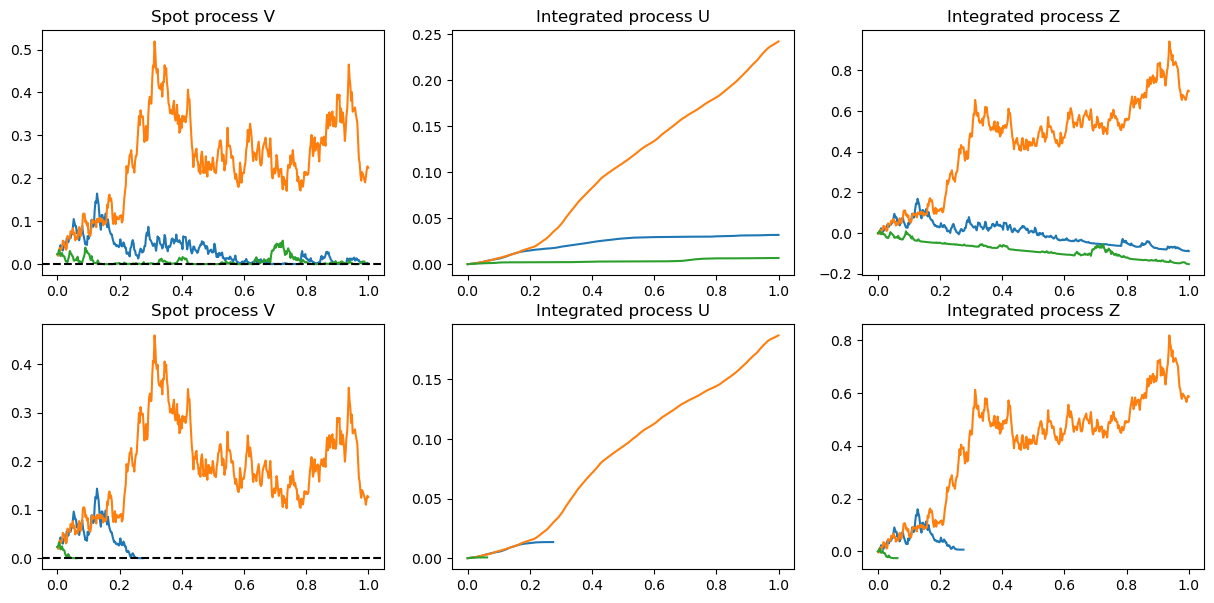

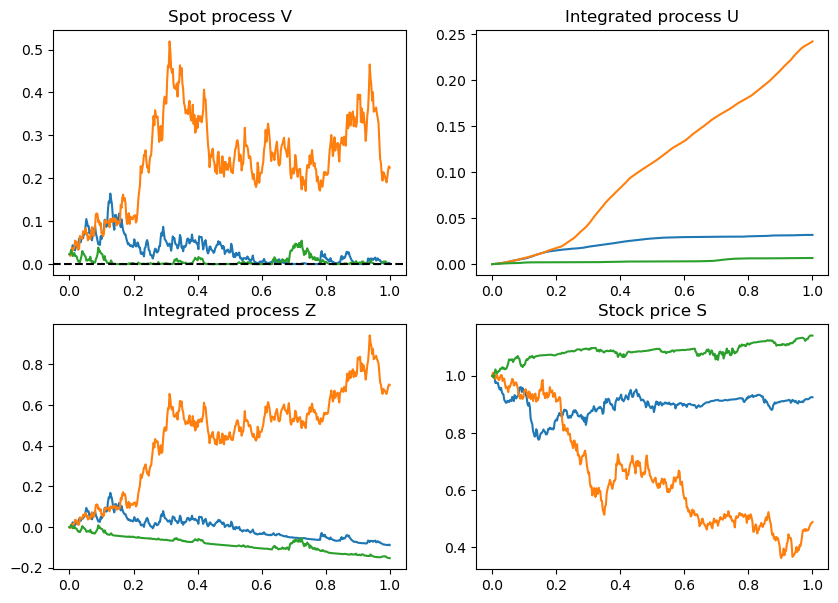

In [11]:
T = 1.
n_steps, n_paths = 400, 3

a, b, c, rho, V_0, T = case[1]

t_vec, V, U, Z, S = simulate_paths(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.)
t_vec, V_abs, U_abs, Z_abs, S_abs = simulate_paths(0., b, c, rho, V_0, T, n_steps, n_paths, S_0=1.)


fig = plt.figure(figsize=(15,7))
plt.subplot(2, 3, 1)
plt.plot(t_vec, V[:, 0:10])
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.title(f'Spot process V')
plt.subplot(2, 3, 2)
plt.plot(t_vec, U[:, 0:10])
plt.title('Integrated process U')
plt.subplot(2, 3, 3)
plt.plot(t_vec, Z[:, 0:10])
plt.title('Integrated process Z')
plt.subplot(2, 3, 4)
plt.plot(t_vec, V_abs[:, 0:10])
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.title(f'Spot process V')
plt.subplot(2, 3, 5)
plt.plot(t_vec, U_abs[:, 0:10])
plt.title('Integrated process U')
plt.subplot(2, 3, 6)
plt.plot(t_vec, Z_abs[:, 0:10])
plt.title('Integrated process Z')
plt.savefig("sample_paths_VUZ.pdf", format='pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10,7))
plt.subplot(2, 2, 1)
plt.plot(t_vec, V[:, 0:10])
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.title(f'Spot process V')
plt.subplot(2, 2, 2)
plt.plot(t_vec, U[:, 0:10])
plt.title('Integrated process U')
plt.subplot(2, 2, 3)
plt.plot(t_vec, Z[:, 0:10])
plt.title('Integrated process Z')
plt.subplot(2, 2, 4)
plt.plot(t_vec, S[:, 0:10])
plt.title('Stock price S')
plt.show()

/tmp/ipykernel_1502799/3071891411.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  samples = np.where(condition, x, (mu ** 2) / x)
/tmp/ipykernel_1502799/3071891411.py:8: RuntimeWarning: invalid value encountered in scalar divide
  x = mu + (mu ** 2 * y) / (2 * lambda_) - (mu / (2 * lambda_)) * np.sqrt(4 * mu * lambda_ * y + mu ** 2 * y ** 2)


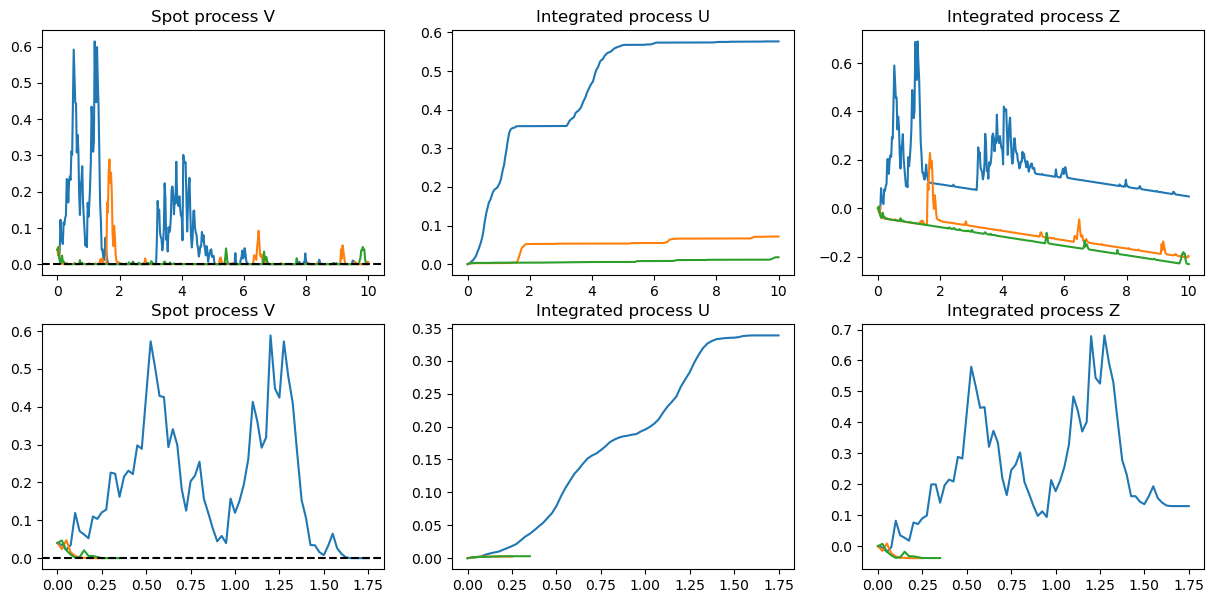

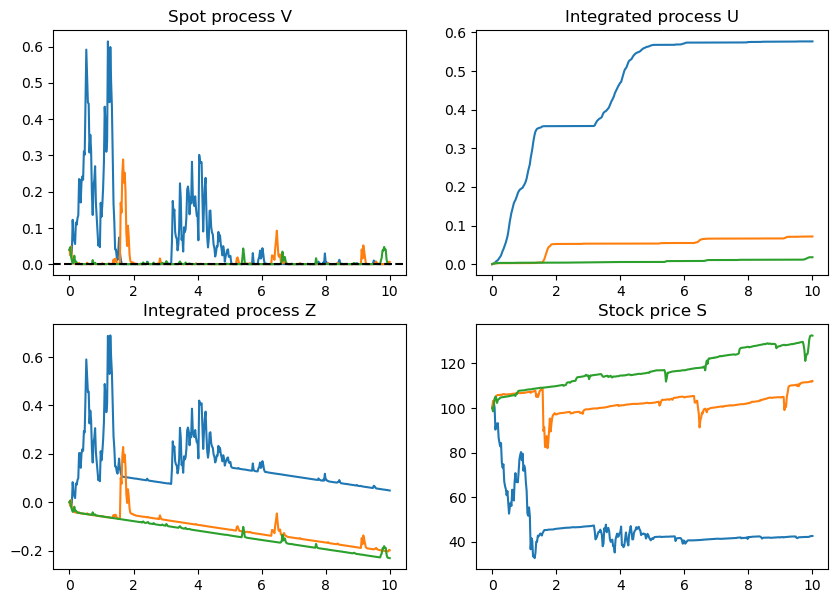

In [12]:
n_steps, n_paths = 400, 3

a, b, c, rho, V_0, T = case[2]

t_vec, V, U, Z, S = simulate_paths(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=100)
t_vec, V_abs, U_abs, Z_abs, S_abs = simulate_paths(0., b, c, rho, V_0, T, n_steps, n_paths, S_0=100)


fig = plt.figure(figsize=(15,7))
plt.subplot(2, 3, 1)
plt.plot(t_vec, V[:, 0:10])
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.title(f'Spot process V')
plt.subplot(2, 3, 2)
plt.plot(t_vec, U[:, 0:10])
plt.title('Integrated process U')
plt.subplot(2, 3, 3)
plt.plot(t_vec, Z[:, 0:10])
plt.title('Integrated process Z')
plt.subplot(2, 3, 4)
plt.plot(t_vec, V_abs[:, 0:10])
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.title(f'Spot process V')
plt.subplot(2, 3, 5)
plt.plot(t_vec, U_abs[:, 0:10])
plt.title('Integrated process U')
plt.subplot(2, 3, 6)
plt.plot(t_vec, Z_abs[:, 0:10])
plt.title('Integrated process Z')
plt.savefig("sample_paths_VUZ.pdf", format='pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10,7))
plt.subplot(2, 2, 1)
plt.plot(t_vec, V[:, 0:10])
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.title(f'Spot process V')
plt.subplot(2, 2, 2)
plt.plot(t_vec, U[:, 0:10])
plt.title('Integrated process U')
plt.subplot(2, 2, 3)
plt.plot(t_vec, Z[:, 0:10])
plt.title('Integrated process Z')
plt.subplot(2, 2, 4)
plt.plot(t_vec, S[:, 0:10])
plt.title('Stock price S')
plt.show()

# Simulation of forward start

In [13]:
#Generate random normals and uniforms and stock them 
random.seed(1)
NNN = 500 #steps
MMM = 1400000 #1_500_000 #number of sample paths
#NNN = 50 #steps
#MMM = 300_000 #number of sample paths
x_norm = np.random.normal(0, 1, (NNN,MMM))
x_norm2 = np.random.normal(0, 1, (NNN,MMM))
x_uniform = np.random.uniform(0, 1, (NNN,MMM))

In [14]:
N_steps = [2, 4, 6, 8, 16, 26, 36, 50, 66, 80, 500]
n_paths = 1400000

In [15]:
# ENFORCE T =  1. first 
S_over_Stmat_1, Vmat_1, Umat_1 = [], [], []
S_over_Stmat_QE_1, Vmat_QE_1, Umat_QE_1 = [], [], []
Smat_Al_1, Vmat_Al_1, Umat_Al_1 = [], [], []
S_0 = 100. 
a, b, c, rho, V_0, T = case[0]

for n_steps in N_steps:
    St, S, V, U= simulate_price_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0)
    S_over_Stmat_1.append([s/st for s, st in zip(S, St)])
#    Vmat_1.append(V)
    Umat_1.append(U)
    St, S, V, U= simulate_price_QE_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0)
    S_over_Stmat_QE_1.append([s/st for s, st in zip(S, St)])
#    Vmat_QE_1.append(V)
    Umat_QE_1.append(U)
    #S,V, U= simulate_price_Alfonsi_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0)
    #Smat_Al_1.append(S)
#    Vmat_QE_1.append(V)
    #Umat_Al_1.append(U)

    print(n_steps)

# ENFORCE T =  1. first 
S_over_Stmat_2, Vmat_2, Umat_2 = [], [], []
S_over_Stmat_QE_2, Vmat_QE_2, Umat_QE_2 = [], [], []
Smat_Al_2, Vmat_Al_2, Umat_Al_2 = [], [], []
S_0 = 100. 
a, b, c, rho, V_0, T = case[1]

for n_steps in N_steps:
    St, S, V, U= simulate_price_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0)
    S_over_Stmat_2.append([s/st for s, st in zip(S, St)])
#    Vmat_2.append(V)
    Umat_2.append(U)
    St, S, V, U= simulate_price_QE_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0)
    S_over_Stmat_QE_2.append([s/st for s, st in zip(S, St)])
#    Vmat_QE_2.append(V)
    Umat_QE_2.append(U)
    #S,V, U= simulate_price_Alfonsi_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0)
    #Smat_Al_2.append(S)
    #Umat_Al_2.append(U)

    print(n_steps)

# ENFORCE T =  10. first 
S_over_Stmat_3, Vmat_3, Umat_3 = [], [], []
S_over_Stmat_QE_3, Vmat_QE_3, Umat_QE_3 = [], [], []
Smat_Al_3, Vmat_Al_3, Umat_Al_3 = [], [], []
S_0 = 100. 
a, b, c, rho, V_0, T = case[2]

for n_steps in N_steps:
    St, S, V, U= simulate_price_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0)
    S_over_Stmat_3.append([s/st for s, st in zip(S, St)])
#    Vmat_3.append(V)
    Umat_3.append(U)
    St, S, V, U= simulate_price_QE_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0)
    S_over_Stmat_QE_3.append([s/st for s, st in zip(S, St)])
#    Vmat_QE_3.append(V)
    #Umat_QE_3.append(U)
    #S,V, U= simulate_price_Alfonsi_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0)
    #Smat_Al_3.append(S)
    #Umat_Al_3.append(U)

    print(n_steps)

2
4
6
8
16
26
36
50
66
80
500
2
4
6
8
16
26
36
50
66
80
500
2
4
6
8
16
26
36
50
66
80
500


## Volatilities references for different values of strike

# CASE 1

In [16]:
#Ref value Fourier 
K_vec = np.linspace(-0.5, 0.5, 800)
K_stars = K_vec + 1

S_0 = 100.
S0 = S_0
r = 0.
#/(-b)
a, b, c, rho, V_0, T = case[0]
kappa, theta, sigma = -b, a/(-b), c 
price_closed =  []
iv = []

for i in range(len(K_vec)):
    price_closed.append(lewis_forward_start_price(K_stars[i], V_0, kappa = kappa, theta = theta, sigma = sigma, rho = rho, t = T/2, T = T, r = 0, alpha = 1.5))
    iv.append(implied_vol_forward_start_bisect(price_closed[i], K_stars[i], t = T/2, T = T))




le prix pour le strike : 0.5 est: 0.5001658782965065
le prix pour le strike : 0.5012515644555695 est: 0.49891703737078463
le prix pour le strike : 0.5025031289111389 est: 0.49766814278861504
le prix pour le strike : 0.5037546933667083 est: 0.4964191729691585
le prix pour le strike : 0.5050062578222778 est: 0.4951701260517365
le prix pour le strike : 0.5062578222778473 est: 0.4939210196968419
le prix pour le strike : 0.5075093867334168 est: 0.4926718882741321
le prix pour le strike : 0.5087609511889862 est: 0.49142277605118867
le prix pour le strike : 0.5100125156445556 est: 0.49017372906533596
le prix pour le strike : 0.5112640801001251 est: 0.4889247866897938
le prix pour le strike : 0.5125156445556946 est: 0.4876759746482665
le prix pour le strike : 0.5137672090112642 est: 0.48642730083160846
le prix pour le strike : 0.5150187734668336 est: 0.4851787546649269
le prix pour le strike : 0.516270337922403 est: 0.4839303100066086
le prix pour le strike : 0.5175219023779725 est: 0.48268193

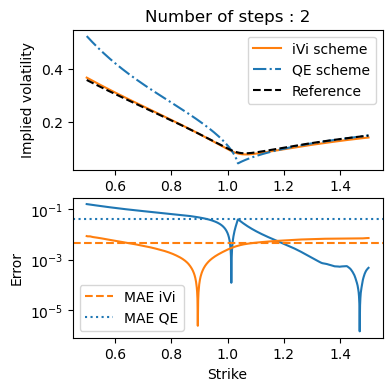

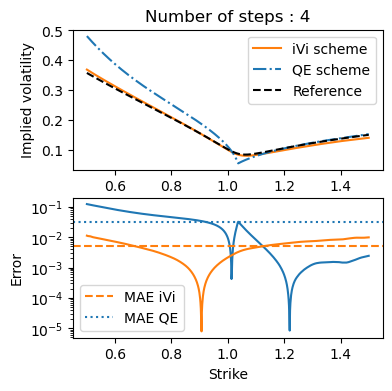

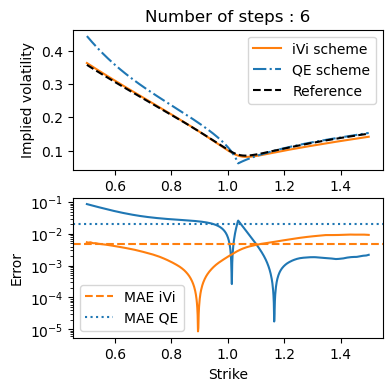

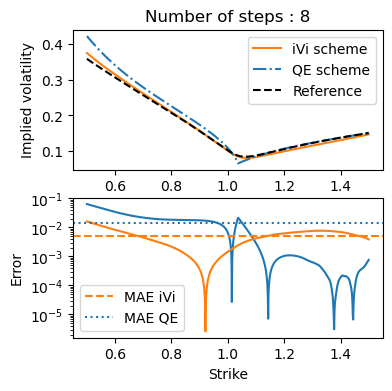

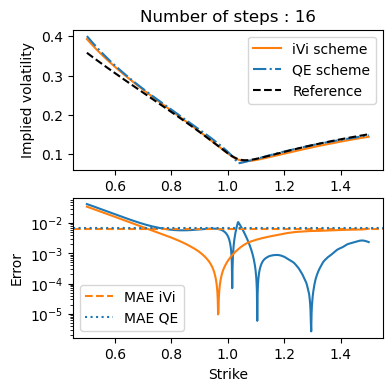

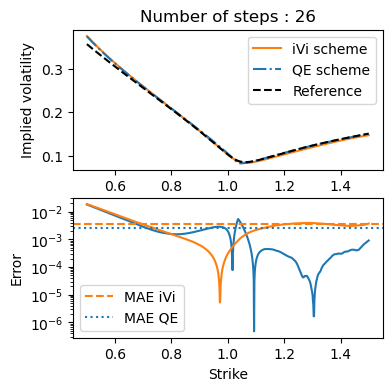

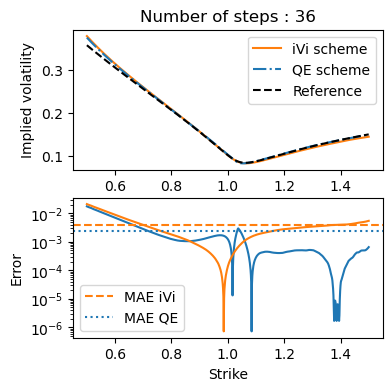

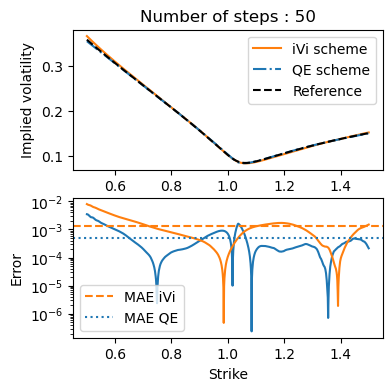

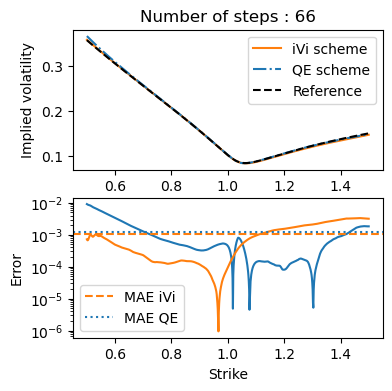

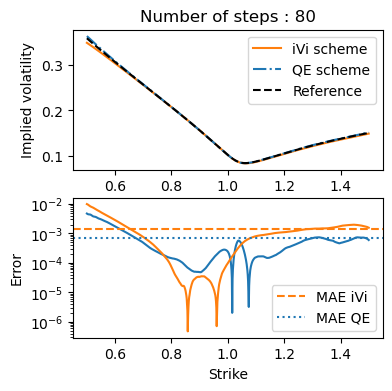

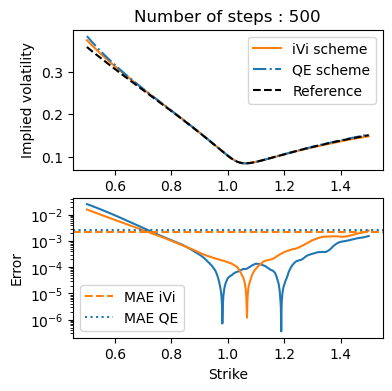

In [17]:

for I in range(11):
    MC_mean_vec = []
    MC_std_vec = []
    MC_QE_mean_vec = []
    MC_QE_std_vec  = []
    MC_Al_mean_vec = []
    MC_Al_std_vec  = []

    for K in K_stars:
        MC_mean = np.mean(np.maximum(S_over_Stmat_1[I] - K, 0.))
        MC_std = np.std(np.maximum(S_over_Stmat_1[I] - K, 0.))
        MC_mean_vec.append(MC_mean)
        MC_std_vec.append(MC_std)
        MC_QE_mean = np.mean(np.maximum(S_over_Stmat_QE_1[I] - K, 0.))
        MC_QE_std = np.std(np.maximum(S_over_Stmat_QE_1[I] - K, 0.))
        MC_QE_mean_vec.append(MC_QE_mean)
        MC_QE_std_vec.append(MC_QE_std)
        
    MC_iv = []
    MC_QE_iv = []

    for i in range(len(K_stars)):
        MC_iv.append(implied_vol_forward_start_bisect(np.array(MC_mean_vec)[i], K_stars[i], T/2, T, r = 0))
        MC_QE_iv.append(implied_vol_forward_start_bisect(np.array(MC_QE_mean_vec)[i], K_stars[i], T/2, T, r = 0))


    nsteps = N_steps[I]


    total_error =  np.mean(np.abs(np.array(MC_iv) - iv))
    total_error_QE =  np.mean(np.abs(np.array(MC_QE_iv) - iv))


    fig = plt.figure(figsize=(4,4))
    plt.subplot(2, 1, 1)
    plt.plot(K_stars, MC_iv, color='#ff7f0e', label = 'iVi scheme')
    plt.plot(K_stars, MC_QE_iv,   color = '#1f77b4',  linestyle = '-.',label = 'QE scheme')
    #plt.plot(K_vec, MC_Al_iv,   color = 'red',  linestyle = '-.',label = 'Alfonsi scheme')
    plt.plot(K_stars, iv, label = 'Reference', linestyle = '--', color = 'black')
    plt.legend()
    plt.ylabel(f"Implied volatility")
    plt.title(f"Number of steps : {nsteps}")
    plt.subplot(2, 1, 2)
    plt.plot(K_stars, np.abs(np.array(MC_QE_iv) - iv))
    plt.plot(K_stars, np.abs(np.array(MC_iv) - iv))
    #plt.plot(K_vec, np.abs(np.array(MC_Al_iv) - iv), color='red')
    plt.axhline(y= total_error, color= '#ff7f0e',  linestyle = '--', label = 'MAE iVi')
    plt.axhline(y= total_error_QE, color = '#1f77b4', linestyle = ':', label = 'MAE QE')
    #plt.axhline(y= total_error_Al, color = 'red', linestyle = ':', label = 'MAE Alfonsi')
    #plt.title(f"Error in prices")
    plt.ylabel(f"Error")
    plt.yscale("log")
    plt.xlabel("Strike")
    plt.legend()
    plt.savefig("Vol_Case1_1.pdf", format='pdf', bbox_inches='tight')
    plt.show()

# CASE 2

In [18]:
#Ref value Fourier 
K_vec = np.linspace(-0.5, 1, 800)
K_stars = K_vec + 1
 
S_0 = 100.
S0 = S_0
r = 0.
#/(-b)
a, b, c, rho, V_0, T = case[1]
kappa, theta, sigma = -b, a/(-b), c 
price_closed =  []
iv = []

for i in range(len(K_vec)):
    price_closed.append(lewis_forward_start_price(K_stars[i], V_0, kappa = kappa, theta = theta, sigma = sigma, rho = rho, t = T/2, T = T, r = 0, alpha = 1.5))
    iv.append(implied_vol_forward_start_bisect(price_closed[i], K_stars[i], t = T/2, T = T))



le prix pour le strike : 0.5 est: 0.5007493996289971
le prix pour le strike : 0.5018773466833542 est: 0.4988876754038374
le prix pour le strike : 0.5037546933667083 est: 0.4970262360896275
le prix pour le strike : 0.5056320400500626 est: 0.49516508176083807
le prix pour le strike : 0.5075093867334168 est: 0.4933042094035829
le prix pour le strike : 0.509386733416771 est: 0.491443615537253
le prix pour le strike : 0.5112640801001251 est: 0.48958329896455244
le prix pour le strike : 0.5131414267834793 est: 0.48772326260735976
le prix pour le strike : 0.5150187734668336 est: 0.4858635137577366
le prix pour le strike : 0.5168961201501877 est: 0.4840040627031026
le prix pour le strike : 0.518773466833542 est: 0.4821449203169207
le prix pour le strike : 0.5206508135168961 est: 0.4802860955851692
le prix pour le strike : 0.5225281602002503 est: 0.4784275940152586
le prix pour le strike : 0.5244055068836044 est: 0.47656941747217785
le prix pour le strike : 0.5262828535669587 est: 0.47471156539

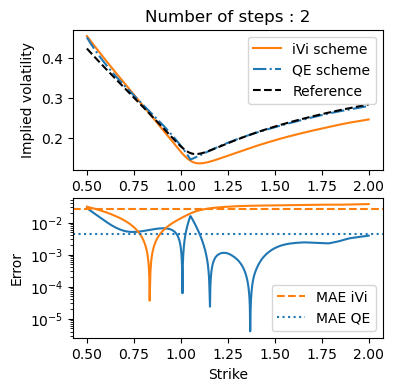

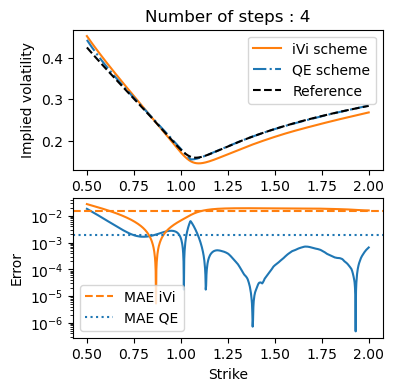

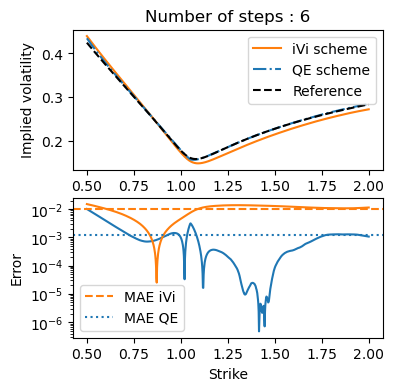

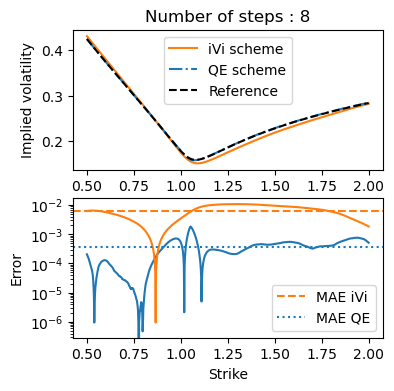

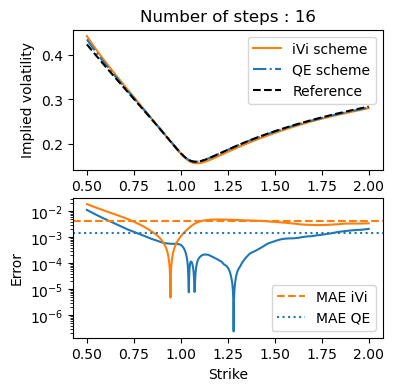

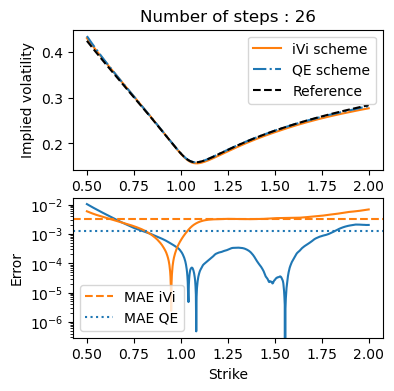

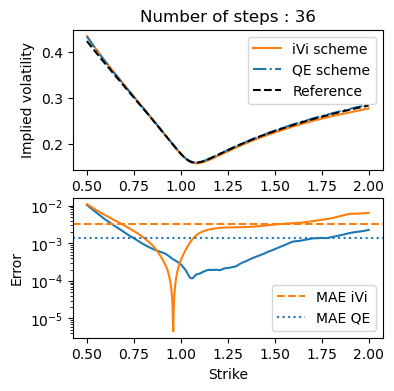

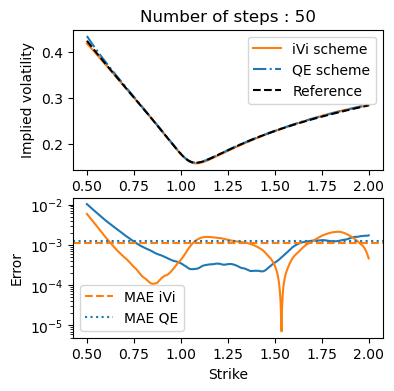

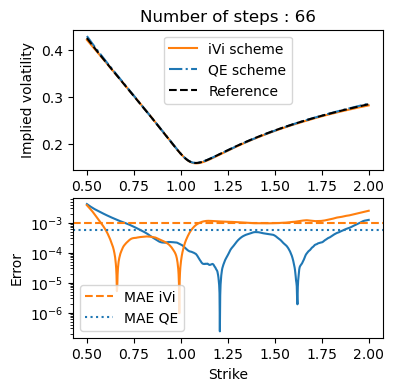

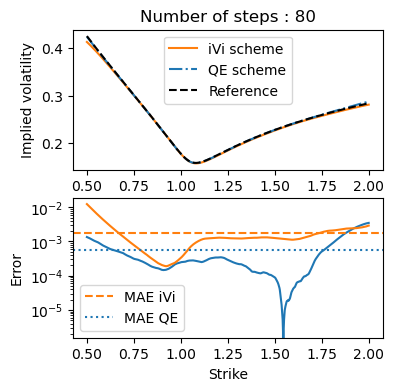

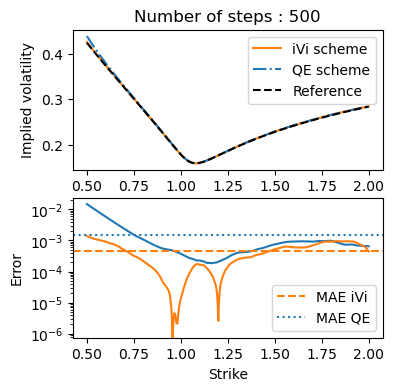

In [19]:

for I in range(11):
    MC_mean_vec = []
    MC_std_vec = []
    MC_QE_mean_vec = []
    MC_QE_std_vec  = []
    MC_Al_mean_vec = []
    MC_Al_std_vec  = []

    for K in K_stars:
        MC_mean = np.mean(np.maximum(S_over_Stmat_2[I] - K, 0.))
        MC_std = np.std(np.maximum(S_over_Stmat_2[I] - K, 0.))
        MC_mean_vec.append(MC_mean)
        MC_std_vec.append(MC_std)
        MC_QE_mean = np.mean(np.maximum(S_over_Stmat_QE_2[I] - K, 0.))
        MC_QE_std = np.std(np.maximum(S_over_Stmat_QE_2[I] - K, 0.))
        MC_QE_mean_vec.append(MC_QE_mean)
        MC_QE_std_vec.append(MC_QE_std)
        
    MC_iv = []
    MC_QE_iv = []

    for i in range(len(K_stars)):
        MC_iv.append(implied_vol_forward_start_bisect(np.array(MC_mean_vec)[i], K_stars[i], T/2, T, r = 0))
        MC_QE_iv.append(implied_vol_forward_start_bisect(np.array(MC_QE_mean_vec)[i], K_stars[i], T/2, T, r = 0))


    nsteps = N_steps[I]


    total_error =  np.mean(np.abs(np.array(MC_iv) - iv))
    total_error_QE =  np.mean(np.abs(np.array(MC_QE_iv) - iv))


    fig = plt.figure(figsize=(4,4))
    plt.subplot(2, 1, 1)
    plt.plot(K_stars, MC_iv, color='#ff7f0e', label = 'iVi scheme')
    plt.plot(K_stars, MC_QE_iv,   color = '#1f77b4',  linestyle = '-.',label = 'QE scheme')
    #plt.plot(K_vec, MC_Al_iv,   color = 'red',  linestyle = '-.',label = 'Alfonsi scheme')
    plt.plot(K_stars, iv, label = 'Reference', linestyle = '--', color = 'black')
    plt.legend()
    plt.ylabel(f"Implied volatility")
    plt.title(f"Number of steps : {nsteps}")
    plt.subplot(2, 1, 2)
    plt.plot(K_stars, np.abs(np.array(MC_QE_iv) - iv))
    plt.plot(K_stars, np.abs(np.array(MC_iv) - iv))
    #plt.plot(K_vec, np.abs(np.array(MC_Al_iv) - iv), color='red')
    plt.axhline(y= total_error, color= '#ff7f0e',  linestyle = '--', label = 'MAE iVi')
    plt.axhline(y= total_error_QE, color = '#1f77b4', linestyle = ':', label = 'MAE QE')
    #plt.axhline(y= total_error_Al, color = 'red', linestyle = ':', label = 'MAE Alfonsi')
    #plt.title(f"Error in prices")
    plt.ylabel(f"Error")
    plt.yscale("log")
    plt.xlabel("Strike")
    plt.legend()
    plt.savefig("Vol_Case1_1.pdf", format='pdf', bbox_inches='tight')
    plt.show()

# CASE 3

In [20]:
#Ref value Fourier 
K_vec = np.linspace(-0.9, 1, 800)
K_stars = K_vec + 1

S_0 = 100.
S0 = S_0
r = 0.
#/(-b)
a, b, c, rho, V_0, T = case[2]
kappa, theta, sigma = -b, a/(-b), c 
price_closed =  []
iv = []

for i in range(len(K_vec)):
    price_closed.append(lewis_forward_start_price(K_stars[i], V_0, kappa = kappa, theta = theta, sigma = sigma, rho = rho, t = T/2, T = T, r = 0, alpha = 1.5))
    iv.append(implied_vol_forward_start_bisect(price_closed[i], K_stars[i], t = T/2, T = T))


le prix pour le strike : 0.09999999999999998 est: 0.9011611679470466
le prix pour le strike : 0.102377972465582 est: 0.898825780740692
le prix pour le strike : 0.10475594493116391 est: 0.8964904620628626
le prix pour le strike : 0.10713391739674594 est: 0.8941563286099667
le prix pour le strike : 0.10951188986232785 est: 0.8918222380317185
le prix pour le strike : 0.11188986232790987 est: 0.8894890544983319
le prix pour le strike : 0.1142678347934919 est: 0.8871562965594326
le prix pour le strike : 0.11664580725907381 est: 0.8848241593648647
le prix pour le strike : 0.11902377972465583 est: 0.8824924760725875
le prix pour le strike : 0.12140175219023774 est: 0.8801616356289453
le prix pour le strike : 0.12377972465581977 est: 0.8778309147311416
le prix pour le strike : 0.12615769712140168 est: 0.8755012082780872
le prix pour le strike : 0.1285356695869837 est: 0.8731718148433317
le prix pour le strike : 0.13091364205256573 est: 0.8708428438019524
le prix pour le strike : 0.133291614518

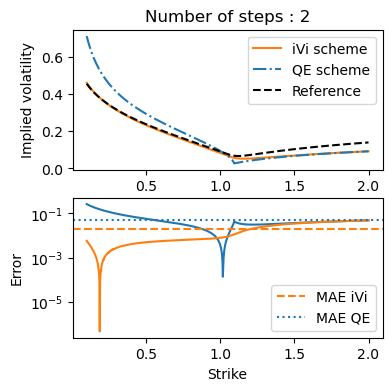

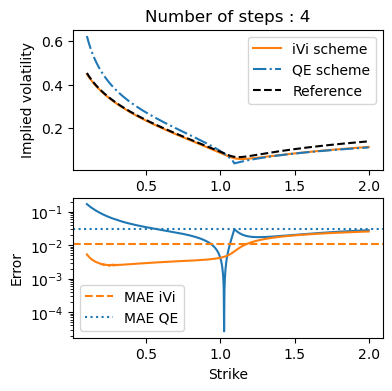

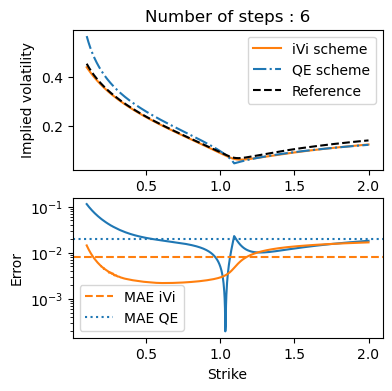

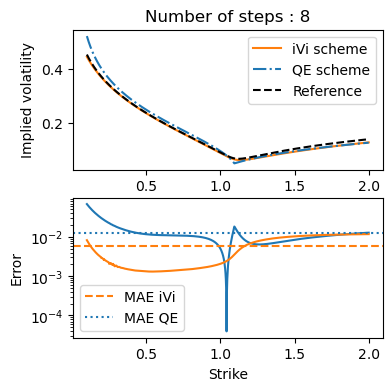

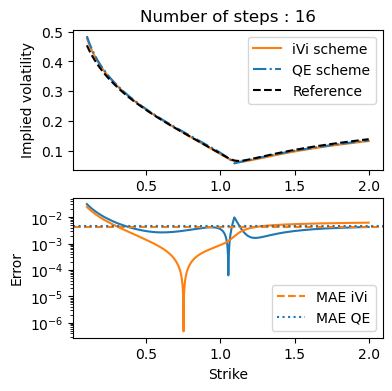

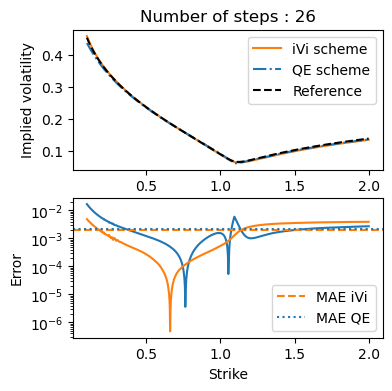

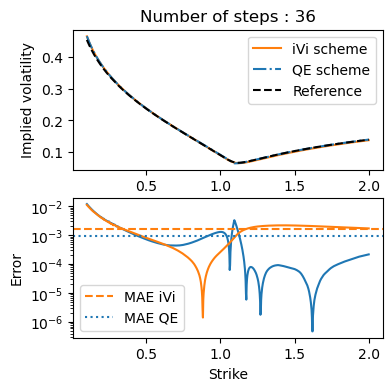

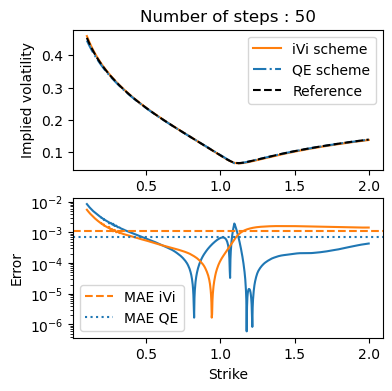

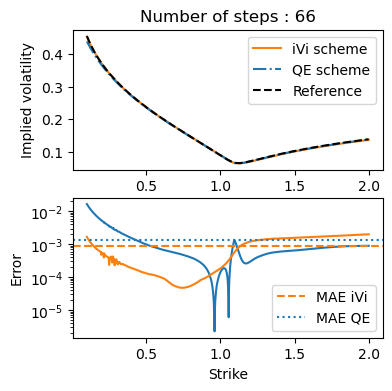

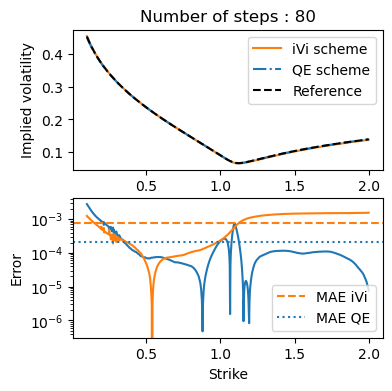

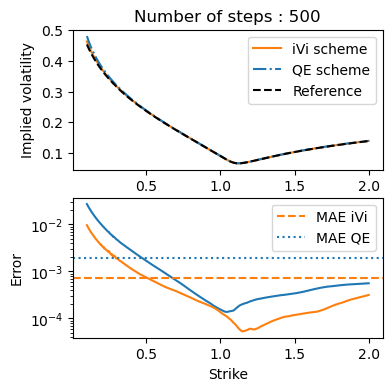

In [21]:
for I in range(11):
    MC_mean_vec = []
    MC_std_vec = []
    MC_QE_mean_vec = []
    MC_QE_std_vec  = []
    MC_Al_mean_vec = []
    MC_Al_std_vec  = []

    for K in K_stars:
        MC_mean = np.mean(np.maximum(S_over_Stmat_3[I] - K, 0.))
        MC_std = np.std(np.maximum(S_over_Stmat_3[I]- K, 0.))
        MC_mean_vec.append(MC_mean)
        MC_std_vec.append(MC_std)
        MC_QE_mean = np.mean(np.maximum(S_over_Stmat_QE_3[I] - K, 0.))
        MC_QE_std = np.std(np.maximum(S_over_Stmat_QE_3[I] - K, 0.))
        MC_QE_mean_vec.append(MC_QE_mean)
        MC_QE_std_vec.append(MC_QE_std)
        
    MC_iv = []
    MC_QE_iv = []

    for i in range(len(K_stars)):
        MC_iv.append(implied_vol_forward_start_bisect(np.array(MC_mean_vec)[i], K_stars[i], T/2, T, r = 0))
        MC_QE_iv.append(implied_vol_forward_start_bisect(np.array(MC_QE_mean_vec)[i], K_stars[i], T/2, T, r = 0))


    nsteps = N_steps[I]


    total_error =  np.mean(np.abs(np.array(MC_iv) - iv))
    total_error_QE =  np.mean(np.abs(np.array(MC_QE_iv) - iv))


    fig = plt.figure(figsize=(4,4))
    plt.subplot(2, 1, 1)
    plt.plot(K_stars, MC_iv, color='#ff7f0e', label = 'iVi scheme')
    plt.plot(K_stars, MC_QE_iv,   color = '#1f77b4',  linestyle = '-.',label = 'QE scheme')
    #plt.plot(K_vec, MC_Al_iv,   color = 'red',  linestyle = '-.',label = 'Alfonsi scheme')
    plt.plot(K_stars, iv, label = 'Reference', linestyle = '--', color = 'black')
    plt.legend()
    plt.ylabel(f"Implied volatility")
    plt.title(f"Number of steps : {nsteps}")
    plt.subplot(2, 1, 2)
    plt.plot(K_stars, np.abs(np.array(MC_QE_iv) - iv))
    plt.plot(K_stars, np.abs(np.array(MC_iv) - iv))
    #plt.plot(K_vec, np.abs(np.array(MC_Al_iv) - iv), color='red')
    plt.axhline(y= total_error, color= '#ff7f0e',  linestyle = '--', label = 'MAE iVi')
    plt.axhline(y= total_error_QE, color = '#1f77b4', linestyle = ':', label = 'MAE QE')
    #plt.axhline(y= total_error_Al, color = 'red', linestyle = ':', label = 'MAE Alfonsi')
    #plt.title(f"Error in prices")
    plt.ylabel(f"Error")
    plt.yscale("log")
    plt.xlabel("Strike")
    plt.legend()
    plt.savefig("Vol_Case1_1.pdf", format='pdf', bbox_inches='tight')
    plt.show()